<a href="https://colab.research.google.com/github/222luke/COMPEVOL/blob/main/ofc-NSGA_II_Otimiza%C3%A7%C3%A3o_de_Microrrede_H%C3%ADbrida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NSGA-II Otimização de Microrrede Híbrida**

**Docente:** Prof. Dr. Edmar Egídio Purcino de Souza

**Discentes:** Gabriel Lucas Nascimento Silva, Márcio Barros Costa Júnior, André Paiva Conrado Rodrigues

In [ ]:
# === INSTALAÇÃO E IMPORTS ===
!pip install pvlib --quiet
!pip install deap --quiet
from google.colab import drive
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
import multiprocessing
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from deap import base, creator, tools
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
np.random.seed(5)

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams['figure.dpi'] = 150

In [ ]:
import warnings

# Supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

# Definição de localização do sistema
location = Location(latitude=-12.709714, longitude=-38.175534, tz='America/Bahia', altitude=400, name='Camacari')

# Importa biblioteca dos parâmetros elétricos dos módulos fotovoltaicos e inversores do GitHub
cec_modules = pvlib.pvsystem.retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Modules.csv')
sapm_inverters = pvlib.pvsystem.retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Inverters.csv')

# Definir o modelo de módulo, inversor e ângulo
module = cec_modules['JA_Solar_JAM72S30_550_MR']
inverter = sapm_inverters['BYD_Auto_Industry_Company_Limited__BEG500KTL_U__480V_']
angulo = 14

# Usar um modelo de temperatura básico com impacto mínimo (por exemplo, NOCT)
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]

# Criar o array da usina solar, definindo albedo e parâmetros de temperatura com impacto mínimo
system = PVSystem(
    name="Camacari",
    surface_tilt=angulo,
    surface_azimuth=0,
    module_parameters=module,
    inverter_parameters=inverter,
    modules_per_string=20,
    strings_per_inverter=32,
    albedo=0.2,  # Configurando a refletância do solo em 20%
    temperature_model_parameters=temperature_model_parameters
)

# Criar o bloco de parametrização da simulação
mc = ModelChain(system, location, aoi_model='no_loss', spectral_model='no_loss')

# Ler o arquivo com os dados TMY reais
tmy = pd.read_csv('https://raw.githubusercontent.com/222luke/COMPEVOL/refs/heads/main/nrel_camacari_timestamp_updated.csv', sep=';', index_col=0)
tmy.index = pd.to_datetime(tmy.index, format="%d/%m/%Y %H:%M")

# Simular o modelo
mc.run_model(tmy)

# Calcular a potência em kW
pot = mc.results.ac / 1000

# Soma total de energia no período
soma_energia = pot.sum()
print(f"Soma total de energia no período: {soma_energia} kWh")

/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2174: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2178: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


Soma total de energia no período: 545613.1397531832 kWh


In [ ]:
# Dados da tabela de consumo específico (m³/kWh)
dados_consumo_especifico = {
    "Potência (kW)": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    "Motor A": [3.24, 1.92, 1.48, 1.28, 1.15, 1.04, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    "Motor B": [3.33, 1.85, 1.41, 1.18, 1.06, 0.96, 0.91, 0.85, 0.82, 0.78, 0.77, 0.75, 0.74, 0.72, 0.70],
    "Motor C": [np.nan, 1.92, 1.48, 1.25, 1.11, 1.02, 0.95, 0.90, 0.85, 0.83, 0.81, 0.78, np.nan, np.nan, np.nan],
    "Motor D": [4.27, 2.39, 1.75, 1.42, 1.24, 1.10, 1.01, 0.95, 0.89, 0.85, 0.81, 0.79, 0.77, 0.74, 0.73],
    "Motor E": [3.71, 2.18, 1.69, 1.42, 1.26, 1.18, 1.10, 1.04, 0.99, 0.96, np.nan, np.nan, np.nan, np.nan, np.nan],
}

# Criar o DataFrame
df_consumo = pd.DataFrame(dados_consumo_especifico)


# Dados da tabela de consumo dos motores geradores (em m³/h)
dados = {
    "Potência (kW)": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], # <- plotar pareto antes e depois da discretização
    "Motor A": [16.19, 19.18, 22.21, 25.52, 28.68, 31.16, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    "Motor B": [16.67, 18.53, 21.15, 23.66, 26.61, 28.84, 31.70, 34.17, 37.08, 39.03, 42.32, 44.70, 48.13, 50.05, 52.77],
    "Motor C": [16.87, 19.19, 22.21, 25.02, 27.79, 30.63, 33.19, 35.99, 38.44, 41.64, 44.72, 47.06, np.nan, np.nan, np.nan],
    "Motor D": [21.36, 23.85, 26.26, 28.42, 31.05, 32.96, 35.23, 37.84, 40.21, 42.57, 44.75, 47.52, 49.76, 51.98, 54.54],
    "Motor E": [18.54, 21.82, 25.37, 28.41, 31.60, 35.27, 38.41, 41.73, 44.65, 48.13, np.nan, np.nan, np.nan, np.nan, np.nan],
}

# Criar o DataFrame
df = pd.DataFrame(dados)


# Dados da Eficiência dos motores geradores (%)
dados_eficiencia = {
    "Potência (kW)": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    "Motor A": [5.34, 9.02, 11.69, 13.56, 15.08, 16.66, 20.91, 22.17, 22.98, 24.26, 24.61, 25.42, 25.58, 26.49, 26.97],
    "Motor B": [5.68, 10.22, 13.43, 16.01, 17.80, 19.70, 21.97, 22.17, 22.98, 22.76, 23.61, 24.12, 25.08, 25.97, 26.97],
    "Motor C": [9.87, 9.87, 12.79, 15.14, 17.04, 18.55, 19.97, 21.05, 22.17, 22.74, 23.29, 24.15, 25.10, 25.90, 27.00],
    "Motor D": [3.58, 6.42, 8.75, 10.78, 12.33, 13.43, 15.21, 16.19, 17.14, 17.99, 18.82, 19.34, 20.17, 20.62, 21.06],
    "Motor E": [5.01, 8.52, 10.99, 13.08, 14.71, 15.84, 16.94, 17.82, 18.73, 19.31, 19.91, 20.42, 20.98, 21.44, 21.90],
}

df_eficiencia = pd.DataFrame(dados_eficiencia)


In [ ]:
# Parâmetros
pot_max_kw = 0     # potência sazonal fixa
carga_constante_kw = 120  # carga constante 24h
dem_min=pot_max_kw+carga_constante_kw
# Índice horário de um ano
index = pd.date_range("2025-01-01", periods=8760, freq="h")

# Inicializa carga constante 24h
carga = pd.Series(carga_constante_kw, index=index)

# Horários típicos de irrigação (manhã e tarde)
horarios_dia = list(range(5, 10)) + list(range(16, 21))

# Mascara booleana para horas de irrigação
mask_irriga = carga.index.hour.isin(horarios_dia)

# Adiciona carga irrigação nos horários definidos
carga.loc[mask_irriga] += pot_max_kw

In [ ]:
#Simulação de microrrede
def simular_microrrede(pot, carga, capacidade_bat,
                       df_consumo,
                       pot_motor_variavel_max,
                       nome_motor_fixo='Motor D',
                       pot_motor_fixo=None,
                       nome_motor_variavel='Motor B',
                       pot_max_bat=120, dod_max=0.8,
                       eta_charge=0.9, eta_discharge=0.9,
                       demanda_contratada=dem_min, preco_gas=1.80,
                       ano_inicial=2025):

    # === Tarifas e compensação (Lei 14.300) === A4 VERDE
    TE = 0.26248
    TUSD_FioB = 0.10142
    quota_tusd_fiob = [0.45, 0.60, 0.75, 0.90, 0.9]
    anos_ativos = [ano_inicial + i for i in range(len(quota_tusd_fiob))]
    valor_liquido_ano = {ano: TE + (1 - quota) * TUSD_FioB for ano, quota in zip(anos_ativos, quota_tusd_fiob)}

    tarifas = {
        'fora_ponta': 0.3639,
        'ponta': 3.1038
    }

    def obter_cec(nome_motor, potencia_uso):
        curva = df_consumo[nome_motor].values
        potencias = df_consumo["Potência (kW)"].values
        return np.interp(potencia_uso, potencias, curva)

    potencias_disponiveis = df_consumo["Potência (kW)"].values
    if pot_motor_fixo is None:
        pot_motor_fixo = potencias_disponiveis[-1]

    # Estado inicial da bateria
    soc = 0.5 * capacidade_bat
    soc_min = capacidade_bat * (1 - dod_max)
    soc_max = capacidade_bat

    # Inicializa listas
    custo_combustivel_fixo = []
    custo_combustivel_var = []
    custo_combustivel = []

    # Inicialização do dataframe
    data_df = pd.DataFrame()
    data_df["pot"] = pot
    data_df["carga"] = carga
    data_df["periodo_tarifa"] = data_df.index.hour.map(lambda x: 'ponta' if 18 <= x <= 20 else 'fora_ponta')
    data_df["noite"] = data_df.index.hour.isin(list(range(18, 24)) + list(range(0, 5)))
    data_df["tarifa"] = data_df["periodo_tarifa"].map(tarifas)

    # Solar atende primeiro
    data_df["solar_para_carga"] = data_df[['pot', 'carga']].min(axis=1)
    data_df["carga_restante"] = data_df['carga'] - data_df['solar_para_carga']
    data_df["pot_gerada_restante"] = data_df['pot'] - data_df['solar_para_carga']

    # Motores só operam no período noturno (18h–4h59)
    data_df["supr_gerador_fixo"] = 0.0
    data_df["supr_gerador_var"] = 0.0
    data_df.loc[data_df["noite"] == True, "supr_gerador_fixo"] = data_df["carga_restante"].clip(upper=pot_motor_fixo)
    data_df.loc[data_df["noite"] == True, "carga_restante"] -= data_df.loc[data_df["noite"] == True, "supr_gerador_fixo"]

    # Motor variável atende restante, respeitando faixa potência
    pot_min = potencias_disponiveis.min()
    pot_max = min(pot_motor_variavel_max, potencias_disponiveis.max())
    pot_disp_clip = potencias_disponiveis[np.logical_and(pot_min <= potencias_disponiveis, potencias_disponiveis <= pot_max)]
    carga_restante_idx = data_df.loc[(data_df["noite"] == True) & (data_df["carga_restante"] > 0)].index

    carga_res_map = data_df.loc[carga_restante_idx, "carga_restante"].to_numpy()
    motor_var_map = np.array([res - pot_disp_clip for res in carga_res_map])
    motor_var_map = np.where(motor_var_map < 0, np.inf, motor_var_map)
    motor_var_map = np.argmin(motor_var_map, axis=1)
    motor_var_pot = pot_disp_clip[motor_var_map].astype("float64")
    data_df.loc[carga_restante_idx, "supr_gerador_var"] = motor_var_pot
    data_df.loc[carga_restante_idx, "carga_restante"] -= data_df.loc[carga_restante_idx, "supr_gerador_var"]

    # Bateria tenta suprir o que resta
    carga_restante_idx = data_df.loc[data_df["carga_restante"] > 0].index
    pot_restante_idx = data_df.loc[data_df["pot_gerada_restante"] > 0].index
    carga_ou_pot_restante_idx = data_df.loc[(data_df["carga_restante"] > 0) | (data_df["pot_gerada_restante"] > 0)].index
    data_df["energia_suprida_bat"] = 0.0
    data_df.loc[carga_restante_idx, "soc"] = soc

    carga_res_arr = data_df.loc[carga_ou_pot_restante_idx, "carga_restante"].to_numpy()
    pot_res_arr = data_df.loc[carga_ou_pot_restante_idx, "pot_gerada_restante"].to_numpy()

    carga_real_list = []
    supr_bat_list = []
    soc_list = []

    data_df.loc[data_df.index[0], "soc"] = soc

    for carga_res, pot_res in zip(carga_res_arr, pot_res_arr):
        # Bateria
        if carga_res > 0:
            energia_extraivel = min((soc - soc_min) * eta_discharge, pot_max_bat)
            supr_bat = min(carga_res, energia_extraivel)
            supr_bat_list.append(supr_bat)
            soc -= supr_bat / eta_discharge

        # Armazenar excedente solar
        if pot_res > 0:
            energia_armazenavel = min(pot_res * eta_charge, pot_max_bat * eta_charge)
            espaco_disp = soc_max - soc
            carga_real = min(energia_armazenavel, espaco_disp)
            soc += carga_real
            carga_real_list.append(carga_real)

        soc_list.append(soc)

    # Fill
    data_df.loc[carga_ou_pot_restante_idx, "soc"] = soc_list
    data_df["soc"] = data_df["soc"].ffill()
    data_df.loc[carga_restante_idx, "energia_suprida_bat"] = supr_bat_list

    # Atualização da carga restante e da potência gerada restante
    data_df.loc[carga_restante_idx, "carga_restante"] -= data_df.loc[carga_restante_idx, "energia_suprida_bat"]
    data_df.loc[pot_restante_idx, "pot_gerada_restante"] -= np.array(carga_real_list) / eta_charge

    # Custo de compra da rede
    data_df["custo_compra_rede"] = data_df["carga_restante"] * data_df["tarifa"]

    # Créditos por injeção de energia solar
    data_df["valor_credito"] = data_df.index.year.map(lambda ano: valor_liquido_ano.get(ano, TE))
    data_df["credito_energia"] = data_df["pot_gerada_restante"] * data_df["valor_credito"]

    # Consumo específico e custo combustível
    data_df["cec_fixo"] = data_df["supr_gerador_fixo"].apply(lambda x: obter_cec(nome_motor_fixo, x))
    data_df["cec_var"] = data_df["supr_gerador_var"].apply(lambda x: obter_cec(nome_motor_variavel, x))
    data_df["custo_comb_m3_fixo"] = data_df["supr_gerador_fixo"] * data_df["cec_fixo"] * preco_gas
    data_df["custo_comb_m3_var"] = data_df["supr_gerador_var"] * data_df["cec_var"] * preco_gas
    data_df["custo_comb"] = data_df["custo_comb_m3_fixo"] + data_df["custo_comb_m3_var"]

    # Demanda contratada e ultrapassagem
    demanda_rede_series = data_df["carga_restante"]
    custo_demanda_contratada = 38.61 * demanda_contratada * 12
    demanda_max_mensal = demanda_rede_series.resample("ME").max()
    excedente_kw_mensal = demanda_max_mensal - demanda_contratada
    excedente_kw_mensal[excedente_kw_mensal < 0] = 0
    custo_ultrapassagem = (excedente_kw_mensal * 77.22).sum()
    custo_total_demanda = custo_demanda_contratada + custo_ultrapassagem

    return {
        "soc": data_df["soc"],
        "energia_suprida_bateria":  data_df["energia_suprida_bat"],
        "energia_comprada_rede": data_df["carga_restante"],
        "energia_injetada_solar": data_df[ "pot_gerada_restante"],
        "energia_solar_para_carga": data_df["solar_para_carga"],
        "energia_suprida_gerador_fixo": data_df["supr_gerador_fixo"],
        "energia_suprida_gerador_var": data_df["supr_gerador_var"],
        "custo_combustivel_fixo": data_df["custo_comb_m3_fixo"],
        "custo_combustivel_var": data_df["custo_comb_m3_var"],
        "custo_combustivel": data_df["custo_comb"],
        "custo_compra_rede": data_df["custo_compra_rede"],
        "credito_geracao_excedente": data_df["credito_energia"],
        "custo_demanda": custo_total_demanda,
        "capacidade_utilizada": capacidade_bat,
        "motor_fixo": nome_motor_fixo,
        "motor_variavel": nome_motor_variavel,
        "pot_motor_fixo": pot_motor_fixo,
        "pot_motor_variavel": pot_motor_variavel_max,
        "custo_combustivel_anual": data_df["custo_comb"].sum()
    }


In [ ]:
def lcoe_bateria_obj(x, pot, carga, df_consumo):
    capacidade = float(x[0])
    pot_var = float(x[1])

    if capacidade < 10 or capacidade > 500 or pot_var < 5:
        return 1e6

    nome_motor_fixo = "Motor D"
    nome_motor_var = "Motor B"

    resultado = simular_microrrede(pot, carga, capacidade,
                                   df_consumo,
                                   pot_motor_variavel_max=pot_var,
                                   nome_motor_fixo=nome_motor_fixo,
                                   nome_motor_variavel=nome_motor_var)

    energia_bat = resultado["energia_suprida_bateria"].sum()
    if energia_bat == 0:
        return 1e6

    capex = capacidade * 2.8
    taxa = 0.08
    n = 25
    vida_bat = 10

    fluxo_reposicoes = sum(capex / ((1 + taxa)**ano) for ano in range(vida_bat, n, vida_bat))
    opex_anual = 0.02 * capex
    fluxo_opex = sum(opex_anual / ((1 + taxa)**ano) for ano in range(1, n + 1))

    ultima_sub = max([ano for ano in range(vida_bat, n + 1, vida_bat) if ano <= n], default=0)
    vida_restante = vida_bat - (n - ultima_sub)
    salvage = capex * (vida_restante / vida_bat) if vida_restante > 0 else 0
    valor_presente_salvage = salvage / ((1 + taxa) ** n)

    vpl_total = fluxo_reposicoes + fluxo_opex - valor_presente_salvage
    crf = (taxa * (1 + taxa)**n) / ((1 + taxa)**n - 1)
    custo_anualizado = (vpl_total + capex) * crf
    return custo_anualizado / energia_bat

def lcoe_total_obj(x, pot, carga, df_consumo):  # adicionar quantização de pot_var no lcoe_total
    capacidade = float(x[0])
    pot_var = float(x[1])

    # Restrições básicas
    if capacidade < 10 or capacidade > 500 or pot_var < 5:
        return 1e6

    nome_motor_fixo = "Motor D"
    nome_motor_var = "Motor B"

    # Simula a microrrede
    resultado = simular_microrrede(
        pot, carga, capacidade,
        df_consumo,
        pot_motor_variavel_max=pot_var,
        nome_motor_fixo=nome_motor_fixo,
        nome_motor_variavel=nome_motor_var
    )

    # Energia útil: soma da energia que efetivamente atende à carga
    energia_util = carga.sum() + resultado["energia_injetada_solar"].sum()        # solar consumida pela rede

    if energia_util == 0:
        return 1e6

    # Parâmetros financeiros e físicos
    modules_per_string = 20
    strings_per_inverter = 32
    custo_modulo = 550
    valor_FV = 3
    valor_BESS = 5
    valor_BIOG = 3
    OM_FV = 0.02
    OM_BESS = 0.02
    OM_BIOG = 0.2

    capex_solar = modules_per_string * strings_per_inverter * custo_modulo * valor_FV
    capex_bat = (capacidade/3)* valor_BESS
    capex_BIOG = valor_BIOG * (resultado["pot_motor_fixo"] + pot_var)
    capex_total = capex_solar + capex_bat + capex_BIOG

    taxa = 0.08
    n = 25
    vida_bat = 10

    # VPL Reposições descontado
    fluxo_reposicoes = sum(
        capex_bat / ((1 + taxa) ** ano) for ano in range(vida_bat, n + 1, vida_bat)
    )

    # VPL OPEX anual fixo e descontado
    opex_anual = OM_BESS * capex_bat + OM_FV * capex_solar + OM_BIOG * capex_BIOG
    fluxo_opex = sum(
        opex_anual / ((1 + taxa) ** ano) for ano in range(1, n + 1)
    )

    # Salvage descontado no último ano
    ultima_sub = max([ano for ano in range(vida_bat, n + 1, vida_bat) if ano <= n], default=0)
    vida_restante = vida_bat - (n - ultima_sub)
    salvage = capex_bat * (vida_restante / vida_bat) if vida_restante > 0 else 0
    valor_presente_salvage = salvage / ((1 + taxa) ** n)

    # VPL custos variáveis (rede, demanda, combustível), todos descontados
    fluxo_rede = sum(
        (resultado["custo_compra_rede"].sum() - resultado["credito_geracao_excedente"].sum()) / ((1 + taxa) ** ano)
        for ano in range(1, n + 1)
    )
    fluxo_demanda = sum(
        resultado["custo_demanda"] / ((1 + taxa) ** ano) for ano in range(1, n + 1)
    )
    fluxo_combustivel = sum(
        resultado["custo_combustivel_anual"] / ((1 + taxa) ** ano) for ano in range(1, n + 1)
    )

    # VPL total
    vpl_total = capex_total + fluxo_reposicoes + fluxo_opex + fluxo_rede + fluxo_demanda + fluxo_combustivel - valor_presente_salvage

    # CRF e custo anualizado
    crf = (taxa * (1 + taxa)**n) / ((1 + taxa)**n - 1)
    custo_anualizado = vpl_total * crf

    # Retorna LCOE
    return custo_anualizado / energia_util


def fracao_ren_obj(x, pot, carga, df_consumo): # adicionar quantização de pot_var na fração ren
    capacidade = float(x[0])
    pot_var = float(x[1])

    if capacidade < 10 or capacidade > 10000 or pot_var < 5:
        return 1e6

    nome_motor_fixo = "Motor D"
    nome_motor_var = "Motor B"

    resultado = simular_microrrede(pot, carga, capacidade,
                                   df_consumo,
                                   pot_motor_variavel_max=pot_var,
                                   nome_motor_fixo=nome_motor_fixo,
                                   nome_motor_variavel=nome_motor_var)

    energia_solar_gerada = pot.sum()
    energia_excedente = resultado["energia_injetada_solar"].sum()
    energia_motores = resultado["energia_suprida_gerador_fixo"].sum() + resultado["energia_suprida_gerador_var"].sum()
    energia_comprada = resultado["energia_comprada_rede"].sum()
    energia_renovavel_util =  energia_solar_gerada + energia_motores - energia_comprada

    energia_total = carga.sum() + energia_excedente
    fracao_ren = energia_renovavel_util / energia_total
    return 1 - fracao_ren if fracao_ren >= 0 else 1e6

In [ ]:
# %% 3 — Hiperparâmetros
POP_SIZE   = 60          # múltiplo de 4 <- testar com pop_size maior
N_GEN      = 50          # <-- 100
CX_PROB    = 0.9
MUT_PROB   = 0.2
ETA_CROSS  = 15.0
ETA_MUT    = 20.0

# penalidades iniciais (ficam mais fortes a cada geração)
LAMBDA_G0  = 10_000.0     # para desigualdades
LAMBDA_H0  = 10_000.0     # para igualdade
TOL_H      = 0.01         # tolerância da igualdade

# limites das variáveis (capacidade_bateria, pot_motor_variavel)
BOUNDS = [(120, 620),    # capacidade_bat (kWh)
          (5, 75)]      # pot_motor_variavel (kW)
LOWER = [b[0] for b in BOUNDS]
UPPER = [b[1] for b in BOUNDS]

In [ ]:
# %% 5 — Tipos DEAP
if "FitnessMin" not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMin)

# %% 6 — Toolbox
toolbox = base.Toolbox()

# Registrando atributos com limites distintos
toolbox.register("attr_capacidade", random.uniform, *BOUNDS[0])
toolbox.register("attr_pot_motor", random.uniform, *BOUNDS[1])

# Cria indivíduo com 2 genes: [capacidade_bat, pot_motor_variavel]
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_capacidade, toolbox.attr_pot_motor), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# %% 4 — Função Objetivo
def evaluate(x):
    capacidade = x[0]
    pot_motor = x[1]
    f1 = lcoe_total_obj(x, pot, carga, df_consumo)
    f2 = fracao_ren_obj(x, pot, carga, df_consumo)
    return f1, f2

toolbox.register("evaluate", evaluate)

# Crossover e mutação com limites separados para cada gene
def bounded_crossover(ind1, ind2, eta):
    for i in range(len(ind1)):
        tools.cxSimulatedBinaryBounded(ind1, ind2, low=BOUNDS[i][0], up=BOUNDS[i][1], eta=eta)
    return ind1, ind2

def bounded_mutation(ind, eta, indpb):
    for i in range(len(ind)):
        tools.mutPolynomialBounded(ind, low=BOUNDS[i][0], up=BOUNDS[i][1], eta=eta, indpb=indpb)
    return ind,

toolbox.register("mate", tools.cxSimulatedBinaryBounded,
                 low=LOWER, up=UPPER, eta=ETA_CROSS)
toolbox.register("mutate", tools.mutPolynomialBounded,
                 low=LOWER, up=UPPER, eta=ETA_MUT, indpb=0.5)

def sanitize(individual):
    for i in range(len(individual)):
        val = individual[i]
        if isinstance(val, complex):  # evita números complexos
            val = val.real
        individual[i] = float(min(max(val, LOWER[i]), UPPER[i]))
    return individual

toolbox.register("select", tools.selNSGA2)

In [ ]:
# %% 7 — Loop principal
def nsga2_run(init_number):
    pop = toolbox.population(POP_SIZE)
    penalty_stats, feasible_rate = [], []

    # Avaliar população inicial
    i = 0
    for ind in pop:
        i += 1
        ind.fitness.values = toolbox.evaluate(ind)
    pop = toolbox.select(pop, len(pop))

    for gen in range(1, N_GEN + 1):
        print(f"Inicialização {init_number}, Gen {gen}/{N_GEN}...")
        # penalidades crescem ao longo das gerações
        # Reprodução
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PROB:
                toolbox.mate(c1, c2)
                del c1.fitness.values, c2.fitness.values
        for m in offspring:
            if random.random() < MUT_PROB:
                toolbox.mutate(m)
                sanitize(m)
                del m.fitness.values

        # Avaliar apenas indivíduos novos
        for ind in (i for i in offspring if not i.fitness.valid):
            # CASO O MODELO SEJA SENSÍVEL: CHECAR VARIÁVEL POT_VAR.isin(lista_discreta) E APROXIMAR
            ind.fitness.values = toolbox.evaluate(ind)
            #print(f"Obj1: {ind.fitness.values[0]:.4f}, Obj2: {ind.fitness.values[1]:.4f}")
            #print(f"Indiv: {ind}")
        # Seleção elitista NSGA‑II
        pop = toolbox.select(pop + offspring, POP_SIZE)

        # Estatísticas

        #if gen % 1 == 0 or gen == 1 or gen == N_GEN:
            #print(f"Geração {gen:3d}")

    pop_and_fit = np.array([[ind[0], ind[1], ind.fitness.values[0], 1.0 - ind.fitness.values[1]] for ind in pop])
    df_pop = pd.DataFrame(pop_and_fit, columns=["Capacidade Bat", "Pot Motor Var", "LCOE Total", "Fração Renovável"])
    df_pop["Inicialização"] = init_number
    print(f"Inicialização {init_number} terminada.")

    return df_pop

In [ ]:
# %% 8 — Execução com várias inicializações
READ_CSV_PARETO = True
N_INITIALIZATIONS = 10
PARALLEL = False

if not READ_CSV_PARETO:
    df_pareto = pd.DataFrame()

    if PARALLEL:
        pool = multiprocessing.Pool(processes = 6)
        pareto_pop_list = pool.map(nsga2_run, range(N_INITIALIZATIONS))
        for i in range(len(pareto_pop_list)):
            df_pareto = pd.concat([df_pareto, pareto_pop_list[i]])
    else:
        for i in range(N_INITIALIZATIONS):
            df_pareto = pd.concat([df_pareto, nsga2_run(i)])

    df_pareto.reset_index(inplace=True)

In [ ]:
if READ_CSV_PARETO:
    df_pareto_filtered = pd.read_csv("/content/pareto_10_init_60_popsize_50_gen.csv")
else:
    df_pareto_filtered = df_pareto[df_pareto["LCOE Total"] < 1e6]
    pareto_csv_filename = f"pareto_{N_INITIALIZATIONS}_init_{POP_SIZE}_popsize_{N_GEN}_gen.csv"
    df_pareto_filtered.to_csv(pareto_csv_filename)

In [ ]:
df_pareto_filtered

,Unnamed: 0,index,Capacidade Bat,Pot Motor Var,LCOE Total,Fração Renovável,Inicialização
0,2,2,312.679800,12.207598,0.700688,0.534563,0
1,3,3,499.926285,55.207296,0.780411,0.843382,0
2,4,4,253.467752,25.103710,0.713037,0.619684,0
3,5,5,120.059481,44.970893,0.713228,0.674131,0
4,6,6,120.040850,45.398839,0.714169,0.707586,0
...,...,...,...,...,...,...,...
577,595,55,129.578004,50.414379,0.715939,0.711208,9
578,596,56,268.554147,48.515537,0.741505,0.763649,9
579,597,57,286.233442,47.119024,0.744711,0.770224,9
580,598,58,260.193888,46.256319,0.739972,0.760508,9


In [ ]:
df_pareto_filtered.groupby(["Inicialização"])[["LCOE Total", "Fração Renovável"]].max().agg(["mean", "std"])

,LCOE Total,Fração Renovável
mean,0.780397,0.843365
std,0.000017,0.000034


In [ ]:
df_pareto_filtered.groupby(["Inicialização"])[["LCOE Total", "Fração Renovável"]].min().agg(["mean", "std"])

,LCOE Total,Fração Renovável
mean,0.700693,0.534469
std,0.000018,0.000057


In [ ]:
df_pareto_filtered[df_pareto_filtered["Fração Renovável"] >= 0.7].groupby(["Inicialização"])[["LCOE Total", "Fração Renovável"]].min().agg(["mean", "std"])

,LCOE Total,Fração Renovável
mean,0.714170,0.707586
std,0.000012,0.000022


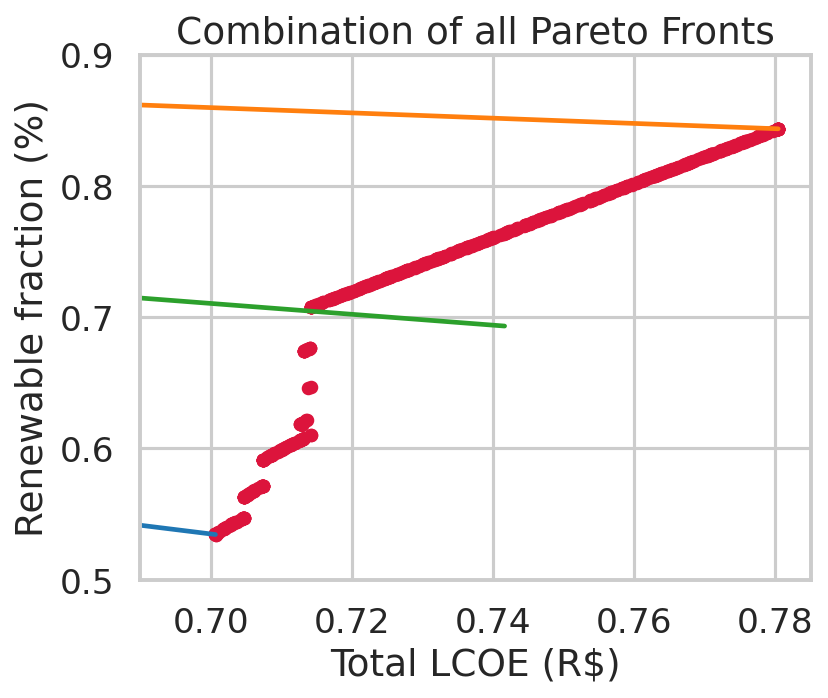

In [ ]:
# %% 9 — Plots
# Cálculo da bissetriz
ponto_o = (0, 1)
ponto_r1 = (df_pareto_filtered["LCOE Total"].min(), df_pareto_filtered["Fração Renovável"].min())
ponto_r2 = (df_pareto_filtered["LCOE Total"].max(), df_pareto_filtered["Fração Renovável"].max())
R1 = np.sqrt((ponto_r1[0] - ponto_o[0])**2 + (ponto_r1[1] - ponto_o[1])**2)
R2 = np.sqrt((ponto_r2[0] - ponto_o[0])**2 + (ponto_r2[1] - ponto_o[1])**2)
D = np.sqrt((ponto_r2[0] - ponto_r1[0])**2 + (ponto_r2[1] - ponto_r1[1])**2)
X_BISS = D/(1 + R2/R1)
PCT_BISS = X_BISS/D
ponto_biss = (ponto_r1[0] + (PCT_BISS*(ponto_r2[0] - ponto_r1[0])), ponto_r1[1] + (PCT_BISS*(ponto_r2[1] - ponto_r1[1])))

# Fronteira aproximada
plt.figure(figsize=(6,5))
plt.scatter(df_pareto_filtered["LCOE Total"], df_pareto_filtered["Fração Renovável"], s=25, c="crimson")
plt.plot([ponto_o[0], ponto_r1[0]], [ponto_o[1], ponto_r1[1]])
plt.plot([ponto_o[0], ponto_r2[0]], [ponto_o[1], ponto_r2[1]])
plt.plot([ponto_o[0], ponto_biss[0]], [ponto_o[1], ponto_biss[1]])
plt.title("Combination of all Pareto Fronts")
plt.xlabel("Total LCOE (R$)"); plt.ylabel("Renewable fraction (%)")
plt.xlim(0.69, 0.785); plt.ylim(0.5, 0.9)
plt.grid(True); plt.tight_layout(); plt.show()


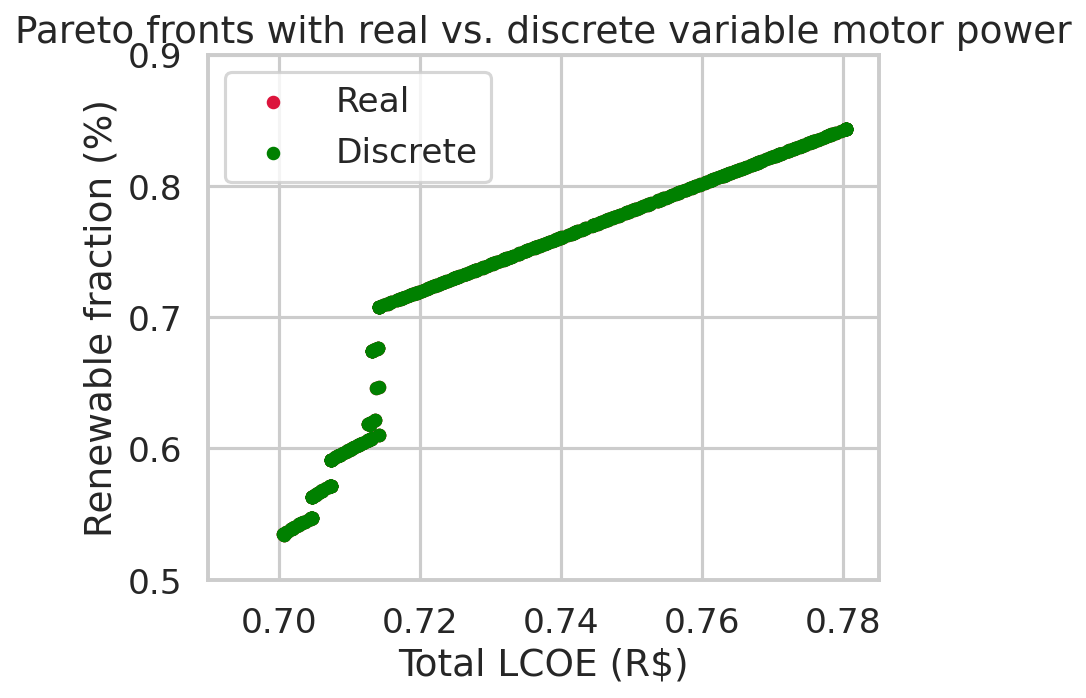

In [ ]:
df_pareto_quantized = df_pareto_filtered.copy()
df_pareto_quantized["Pot Motor Var"] = (df_pareto_quantized["Pot Motor Var"]/5.0).round(0)*5
# Fronteira aproximada
plt.figure(figsize=(6,5))
plt.scatter(df_pareto_filtered["LCOE Total"], df_pareto_filtered["Fração Renovável"], s=25, c="crimson", label="Real")
plt.scatter(df_pareto_quantized["LCOE Total"], df_pareto_quantized["Fração Renovável"], s=25, c="green", label="Discrete")
plt.legend()
#plt.plot([ponto_o[0], ponto_r1[0]], [ponto_o[1], ponto_r1[1]])
#plt.plot([ponto_o[0], ponto_r2[0]], [ponto_o[1], ponto_r2[1]])
#plt.plot([ponto_o[0], ponto_biss[0]], [ponto_o[1], ponto_biss[1]])
plt.title("Pareto fronts with real vs. discrete variable motor power")
plt.xlabel("Total LCOE (R$)"); plt.ylabel("Renewable fraction (%)")
plt.xlim(0.69, 0.785); plt.ylim(0.5, 0.9)
plt.grid(True); plt.tight_layout(); plt.show()

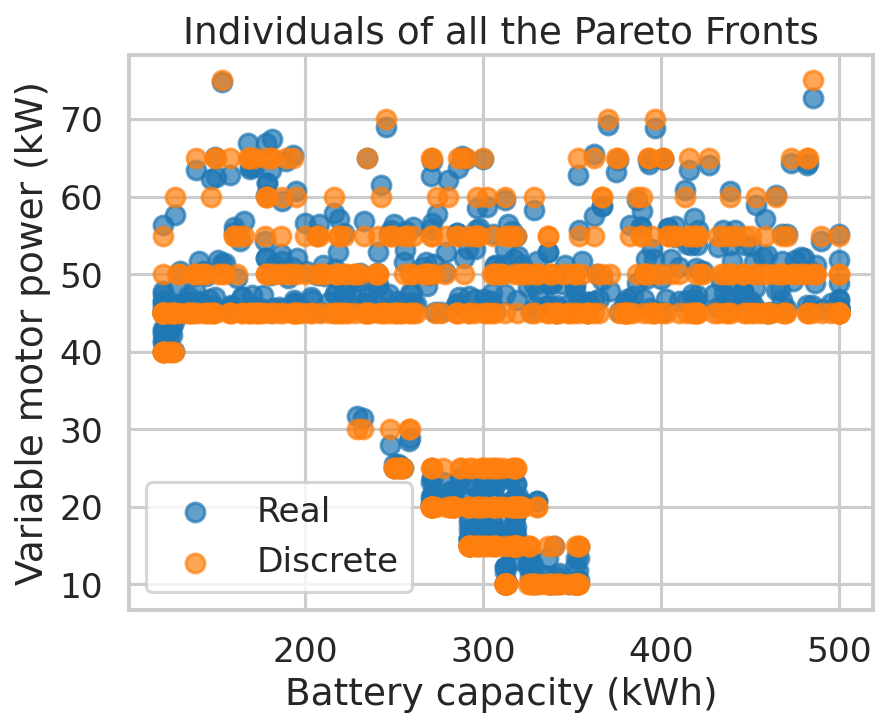

In [ ]:
plt.scatter(df_pareto_filtered["Capacidade Bat"], df_pareto_filtered["Pot Motor Var"], alpha=0.7, label="Real")
plt.scatter(df_pareto_quantized["Capacidade Bat"], df_pareto_quantized["Pot Motor Var"], alpha=0.7, label="Discrete")
plt.legend(loc="lower left")
plt.title("Individuals of all the Pareto Fronts")
plt.xlabel("Battery capacity (kWh)")
plt.ylabel("Variable motor power (kW)")
plt.show()

In [ ]:
# === Parâmetros ótimos da solução ===
capacidade_otima = 310
pot_motor_var = 45

# === Parâmetros fixos dos motores ===
nome_motor_fixo = "Motor D"
pot_motor_fixo = 75.0
nome_motor_variavel = "Motor B"

# === Simular microrrede ===
resultado_otimo = simular_microrrede(
    pot, carga, capacidade_otima,
    df_consumo,
    pot_motor_variavel_max=pot_motor_var,
    nome_motor_fixo=nome_motor_fixo,
    pot_motor_fixo=pot_motor_fixo,
    nome_motor_variavel=nome_motor_variavel
)

# === Parâmetros financeiros ===
taxa = 0.08
n = 25
vida_bat = 10

# === CAPEX solar
modules_per_string = 20
strings_per_inverter = 32
capex_solar = modules_per_string * strings_per_inverter * 550 * 1.85
capex_bat = capacidade_otima * 2.4
capex_total = capex_solar + capex_bat

# === Energia útil
energia_util = (
    resultado_otimo["energia_solar_para_carga"].sum() +
    resultado_otimo["energia_suprida_bateria"].sum() +
    resultado_otimo["energia_comprada_rede"].sum() +
    resultado_otimo["energia_suprida_gerador_fixo"].sum() +
    resultado_otimo["energia_suprida_gerador_var"].sum()
)

# === VPLs
vpl_reposicoes = sum(capex_bat / ((1 + taxa) ** ano) for ano in range(vida_bat, n + 1, vida_bat))
opex_anual = 0.02 * capex_bat + 0.02 * capex_solar
vpl_opex = sum(opex_anual / ((1 + taxa) ** ano) for ano in range(1, n + 1))

ultima_sub = max([ano for ano in range(vida_bat, n + 1, vida_bat) if ano <= n], default=0)
vida_restante = vida_bat - (n - ultima_sub)
salvage = capex_bat * (vida_restante / vida_bat) if vida_restante > 0 else 0
valor_presente_salvage = salvage / ((1 + taxa) ** n)

vpl_rede = sum(
    (resultado_otimo["custo_compra_rede"].sum() - resultado_otimo["credito_geracao_excedente"].sum()) / ((1 + taxa) ** ano)
    for ano in range(1, n + 1)
)
vpl_demanda = sum(resultado_otimo["custo_demanda"] / ((1 + taxa) ** ano) for ano in range(1, n + 1))
vpl_combustivel = sum(resultado_otimo["custo_combustivel_anual"] / ((1 + taxa) ** ano) for ano in range(1, n + 1))

# === VPL total, LCOE e CRF
vpl_total = capex_total + vpl_reposicoes + vpl_opex + vpl_rede + vpl_demanda + vpl_combustivel - valor_presente_salvage
crf = (taxa * (1 + taxa) ** n) / ((1 + taxa) ** n - 1)
custo_anualizado = vpl_total * crf
lcoe_final = custo_anualizado / energia_util

# === Fração renovável (conforme imagem)
energia_solar_util = resultado_otimo["energia_solar_para_carga"].sum()
energia_motores = (
    resultado_otimo["energia_suprida_gerador_fixo"].sum() +
    resultado_otimo["energia_suprida_gerador_var"].sum()
)
energia_renovavel_util = energia_solar_util + energia_motores
energia_total = carga.sum()
fracao_renovavel = energia_renovavel_util / energia_total

# === Tabela LCOE + FR
df_lcoe = pd.DataFrame({
    "Categoria": [
        "CAPEX",
        "VPL Reposições",
        "VPL OPEX",
        "VPL Rede (compra - crédito)",
        "VPL Demanda",
        "VPL Combustível",
        "Valor Residual (salvage)",
        "VPL Total",
        "Custo Anualizado",
        "Energia útil total [kWh]",
        "LCOE [R$/kWh]",
        "Fração renovável"
    ],
    "Valor [R$]": [
        capex_total,
        vpl_reposicoes,
        vpl_opex,
        vpl_rede,
        vpl_demanda,
        vpl_combustivel,
        -valor_presente_salvage,
        vpl_total,
        custo_anualizado,
        energia_util,
        lcoe_final,
        fracao_renovavel
    ]
})

# === Fluxo horário detalhado
df_fluxos = pd.DataFrame({
    "SOC [%]": resultado_otimo["soc"]/capacidade_otima,
    "Potência FV [kW]": pot,
    "Carga [kW]": carga,
    "Energia FV gerada [kWh]": pot,
    "Energia solar para carga [kWh]": resultado_otimo["energia_solar_para_carga"],
    "Energia suprida pela bateria [kWh]": resultado_otimo["energia_suprida_bateria"],
    "Energia comprada da rede [kWh]": resultado_otimo["energia_comprada_rede"],
    "Energia injetada da solar [kWh]": resultado_otimo["energia_injetada_solar"],
    "Energia motor fixo [kWh]": resultado_otimo["energia_suprida_gerador_fixo"],
    "Energia motor variável [kWh]": resultado_otimo["energia_suprida_gerador_var"],
    "Custo da compra de energia [R$]": resultado_otimo["custo_compra_rede"],
    "Custo do combustível motor fixo [R$]": resultado_otimo["custo_combustivel_fixo"],
    "Custo do combustível motor variável [R$]": resultado_otimo["custo_combustivel_var"],
    "Crédito por injeção excedente [R$]": resultado_otimo["credito_geracao_excedente"],
}, index=pot.index)

df_fluxos["Capacidade da bateria [kWh]"] = ""
df_fluxos.loc[df_fluxos.index[0], "Capacidade da bateria [kWh]"] = capacidade_otima

# === Resumo de demanda
custo_total_demanda = resultado_otimo["custo_demanda"]
custo_demanda_contratada = 38.61 * 120 * 12
custo_ultrapassagem = custo_total_demanda - custo_demanda_contratada

df_resumo = pd.DataFrame({
    "Custo de demanda contratada [R$/ano]": [custo_demanda_contratada],
    "Custo de ultrapassagem [R$/ano]": [custo_ultrapassagem],
    "Custo total de demanda [R$/ano]": [custo_total_demanda],
})

# === Gráfico de pizza das fontes
energia_fontes = {
    "FV direta": energia_solar_util,
    "Bateria": resultado_otimo["energia_suprida_bateria"].sum(),
    "Rede": resultado_otimo["energia_comprada_rede"].sum(),
    "Gerador fixo": resultado_otimo["energia_suprida_gerador_fixo"].sum(),
    "Gerador variável": resultado_otimo["energia_suprida_gerador_var"].sum()
}

fig, ax = plt.subplots()
ax.pie(energia_fontes.values(), labels=energia_fontes.keys(), autopct="%1.1f%%", startangle=90)
ax.axis("equal")
plt.title("Contribuição de Energia por Fonte")
plt.savefig("grafico_contribuicao_fontes.png", dpi=300)
plt.close()

# === Salvar Excel com imagem
with pd.ExcelWriter("fluxos_microrrede.xlsx", engine="openpyxl") as writer:
    df_fluxos.to_excel(writer, sheet_name="Fluxo Horário")
    df_resumo.to_excel(writer, sheet_name="Totais e Custos", index=False)
    df_lcoe.to_excel(writer, sheet_name="LCOE Detalhado", index=False)

wb = load_workbook("fluxos_microrrede.xlsx")
ws = wb.create_sheet("Gráfico de Energia")
img = XLImage("grafico_contribuicao_fontes.png")
img.anchor = "A1"
ws.add_image(img)
wb.save("fluxos_microrrede.xlsx")

print("Planilha 'fluxos_microrrede.xlsx' gerada com gráfico.")
print(f"Fração renovável: {fracao_renovavel:.2%}")

Planilha 'fluxos_microrrede.xlsx' gerada com gráfico.
Fração renovável: 79.94%
